# LSTM vs RNN: Handling Long-Term Dependencies
This notebook demonstrates the problem of long-term dependencies with a vanilla RNN and how an LSTM solves it using a synthetic dataset.

In [1]:
!pip install numpy matplotlib tensorflow scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Embedding, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Generate Synthetic Data

In [3]:
def generate_data(sequence_length=50, size=1000):
    np.random.seed(42)
    X = np.linspace(0, 100, size)
    Y = np.sin(X)  # Long-term dependency: sine wave
    # Add noise to simulate a real-world problem
    Y += np.random.normal(0, 0.1, size)
    data = []
    labels = []
    for i in range(len(Y) - sequence_length):
        data.append(Y[i:i + sequence_length])
        labels.append(Y[i + sequence_length])
    return np.array(data), np.array(labels)

sequence_length = 50
X, y = generate_data(sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Add a feature dimension
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1))

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Define and Train RNN Model

In [4]:
rnn_model = Sequential([
    SimpleRNN(10, activation='tanh', input_shape=(sequence_length, 1)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Define and Train LSTM Model

In [5]:
lstm_model = Sequential([
    LSTM(10, activation='tanh', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

## Evaluate Both Models

In [6]:
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform predictions and true values
y_test = scaler.inverse_transform(y_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Calculate RMSE for both models
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

print(f"RNN RMSE: {rnn_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RNN RMSE: 0.2323379897334241
LSTM RMSE: 0.10784236366642287


## Visualize Predictions

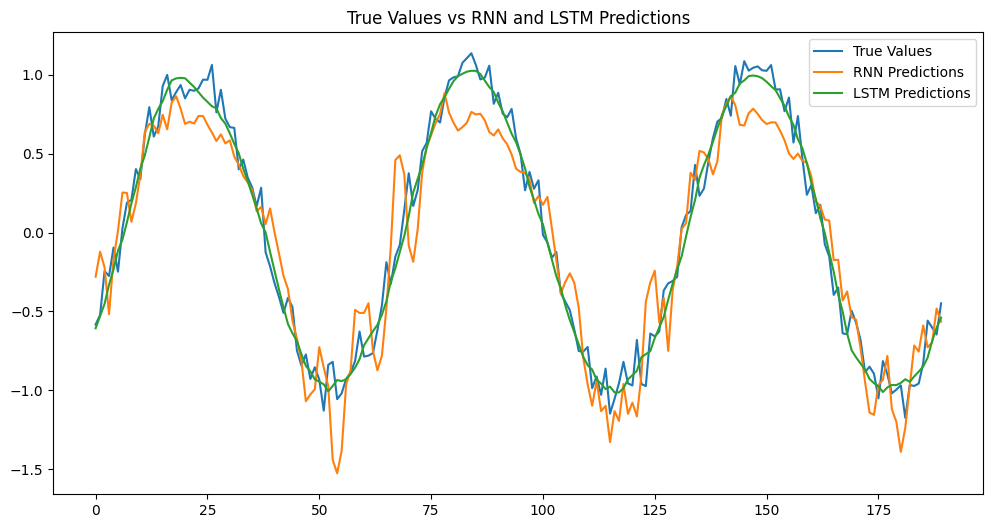

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(rnn_predictions, label='RNN Predictions')
plt.plot(lstm_predictions, label='LSTM Predictions')
plt.legend()
plt.title("True Values vs RNN and LSTM Predictions")
plt.show()

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
from datasets import load_dataset

# Load the WMT English-French dataset
dataset = load_dataset("wmt14", "fr-en", split="train[:1000]")  # Limit to 1000 pairs for demonstration

# Extract English-French sentence pairs
sentence_pairs = [(entry['translation']['en'], entry['translation']['fr']) for entry in dataset]

# Prepare input and target texts
input_texts = [pair[0] for pair in sentence_pairs]
target_texts = [f"\t{pair[1]}\n" for pair in sentence_pairs]  # Add start (\t) and stop (\n) tokens

# Create character vocabularies
input_characters = sorted(set("".join(input_texts)))
target_characters = sorted(set("".join(target_texts)))

input_vocab_size = len(input_characters)
target_vocab_size = len(target_characters)

input_char_to_index = {char: i for i, char in enumerate(input_characters)}
target_char_to_index = {char: i for i, char in enumerate(target_characters)}

input_index_to_char = {i: char for char, i in input_char_to_index.items()}
target_index_to_char = {i: char for char, i in target_char_to_index.items()}

max_input_len = max(len(txt) for txt in input_texts)
max_target_len = max(len(txt) for txt in target_texts)

# One-hot encode input and output
encoder_input_data = np.zeros((len(input_texts), max_input_len, input_vocab_size), dtype="float32")
decoder_input_data = np.zeros((len(target_texts), max_target_len, target_vocab_size), dtype="float32")
decoder_target_data = np.zeros((len(target_texts), max_target_len, target_vocab_size), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_to_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_to_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_char_to_index[char]] = 1.0

# Building the encoder
encoder_inputs = Input(shape=(None, input_vocab_size))
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Building the decoder
decoder_inputs = Input(shape=(None, target_vocab_size))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention Mechanism
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])  # Alignment scores
attention = Activation('softmax', name='attention')(attention)  # Attention weights
context = Dot(axes=[2, 1])([attention, encoder_outputs])  # Context vector

# Concatenate context vector with decoder outputs
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context])

# Dense layer for final output
decoder_dense = Dense(target_vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_combined_context)

# Build the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=10,  # Adjust epochs as needed
    validation_split=0.2,
)

# Save the model
model.save("s2s_attention_translation.h5")

# Creating inference models
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Inputs for the decoder
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse the decoder LSTM and calculate attention
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]  # Correctly define the decoder states for inference

attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention = Activation('softmax', name="attention_inference")(attention)
context = Dot(axes=[2, 1])([attention, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context])
decoder_outputs = decoder_dense(decoder_combined_context)

# Create the final inference model for the decoder
decoder_model = Model(
    [decoder_inputs, encoder_outputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# Translation function
def translate(input_seq):
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, target_vocab_size))
    target_seq[0, 0, target_char_to_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + [state_h, state_c]
        )
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_index_to_char[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_target_len:
            stop_condition = True

        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.0

        state_h, state_c = h, c

    return decoded_sentence

# Testing the model
test_input = "hello"
input_seq = np.zeros((1, max_input_len, input_vocab_size), dtype="float32")
for t, char in enumerate(test_input):
    input_seq[0, t, input_char_to_index[char]] = 1.0

print("Input:", test_input)
print("Translated:", translate(input_seq))


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 165s 12s/step - accuracy: 0.0216 - loss: 0.8883 - val_accuracy: 0.0221 - val_loss: 0.6413
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 205s 12s/step - accuracy: 0.0245 - loss: 0.7058 - val_accuracy: 0.0218 - val_loss: 0.6127
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 193s 11s/step - accuracy: 0.0248 - loss: 0.6987 - val_accuracy: 0.0228 - val_loss: 0.6128
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 11s/step - accuracy: 0.0255 - loss: 0.6852 - val_accuracy: 0.0238 - val_loss: 0.6133
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 150s 12s/step - accuracy: 0.0261 - loss: 0.6878 - val_accuracy: 0.0238 - val_loss: 0.6083
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 148s 11s/step - accuracy: 0.0271 - loss: 0.6893 - val_accuracy: 0.0238 - val_loss: 0.6107
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 202s 12s/step - accuracy: 0.0256 - loss: 0.6657 - val_accuracy: 0.0244 - val_loss: 0.6045
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 12s/step - accuracy: 0.0270 - loss: 0.6924 - val_accuracy: 0.

Input: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

In [15]:
from datasets import load_dataset
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Masking, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")

# Prepare the data
def preprocess_data(data):
    sentences, tags = [], []
    for item in data:
        sentences.append(item["tokens"])
        tags.append(item["ner_tags"])  # Numeric tags
    return sentences, tags

# Process the train, validation, and test splits
train_sentences, train_tags = preprocess_data(dataset["train"])
val_sentences, val_tags = preprocess_data(dataset["validation"])
test_sentences, test_tags = preprocess_data(dataset["test"])

# Map words to indices
all_words = list(set(word for sentence in train_sentences for word in sentence))
word2idx = {word: idx + 1 for idx, word in enumerate(all_words)}  # Start from 1 (reserve 0 for padding)

# Map numeric tags to descriptive tags and vice versa
tag_names = dataset["train"].features["ner_tags"].feature.names  # ['O', 'B-PER', 'I-PER', ...]
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

max_len = 50  # Maximum sentence length

# Encode and pad sentences and tags
def encode_and_pad(sentences, tags, word2idx, max_len):
    X, y = [], []
    for i, sentence in enumerate(sentences):
        # Convert words to indices
        encoded_sentence = [word2idx.get(word, 0) for word in sentence]
        padded_sentence = encoded_sentence + [0] * (max_len - len(encoded_sentence))
        X.append(padded_sentence[:max_len])

        # Pad numeric tags
        encoded_tags = tags[i]
        padded_tags = encoded_tags + [0] * (max_len - len(encoded_tags))  # 0 is the padding tag
        y.append(padded_tags[:max_len])
    return np.array(X), np.array(y)

X_train, y_train = encode_and_pad(train_sentences, train_tags, word2idx, max_len)
X_val, y_val = encode_and_pad(val_sentences, val_tags, word2idx, max_len)
X_test, y_test = encode_and_pad(test_sentences, test_tags, word2idx, max_len)

# Convert y to one-hot encoding
num_tags = len(tag_names)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_tags)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_tags)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_tags)

# Define the model using Functional API
input_layer = Input(shape=(max_len,))
masking_layer = Masking(mask_value=0)(input_layer)  # Explicit masking
embedding_layer = Embedding(input_dim=len(word2idx) + 1, output_dim=128)(masking_layer)
lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2))(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Prediction function
def predict_tags(sentence):
    encoded_sentence = [word2idx.get(word, 0) for word in sentence] + [0] * (max_len - len(sentence))
    encoded_sentence = np.array([encoded_sentence[:max_len]])
    predictions = model.predict(encoded_sentence)
    predicted_tags = np.argmax(predictions, axis=-1)
    return [idx2tag[idx] for idx in predicted_tags[0][:len(sentence)]]

# Test the model
example_sentence = ["Elon", "Musk", "is", "the", "CEO", "of", "Tesla"]
print("Input Sentence:", example_sentence)
print("Predicted Tags:", predict_tags(example_sentence))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'embedding_6' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


439/439 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.9390 - loss: 0.2965 - val_accuracy: 0.9691 - val_loss: 0.2384
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 125ms/step - accuracy: 0.9831 - loss: 0.0577 - val_accuracy: 0.9821 - val_loss: 0.2018
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9956 - loss: 0.0183 - val_accuracy: 0.9840 - val_loss: 0.1937
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.9981 - loss: 0.0085 - val_accuracy: 0.9846 - val_loss: 0.1935
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9848 - val_loss: 0.1942
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9846 - val_loss: 0.1958
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 126ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9848 - val_loss: 0.1971
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9780 - loss: 0.2846
Test Loss: 0.25942